In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")
import datetime

In [79]:
import datetime
from pandas_datareader import data

start_date = datetime.datetime(2012, 1, 3)
end_date = datetime.datetime(2020, 1, 9)

df = data.DataReader(name="AAPL", data_source="yahoo", start=start_date, end=end_date)
df.to_csv("AAPL.csv") # save file to .csv
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-03,300.579987,296.500000,297.149994,297.429993,36580700.0,295.924713
2020-01-06,299.959991,292.750000,293.790009,299.799988,29596800.0,298.282715
2020-01-07,300.899994,297.480011,299.839996,298.390015,27218000.0,296.879883
2020-01-08,304.440002,297.160004,297.160004,303.190002,33019800.0,301.655548
2020-01-09,310.429993,306.200012,307.239990,309.630005,42527100.0,308.062988


In [93]:
data = pd.read_csv("AAPL.csv")
print('Number of items:', data.shape[0])
data.head()

Number of items: 2018


,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.857235
1,2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.130558
2,2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.698215
3,2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.238651
4,2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.155792


In [92]:
data.shape

(2018, 7)

<IPython.core.display.Javascript object>


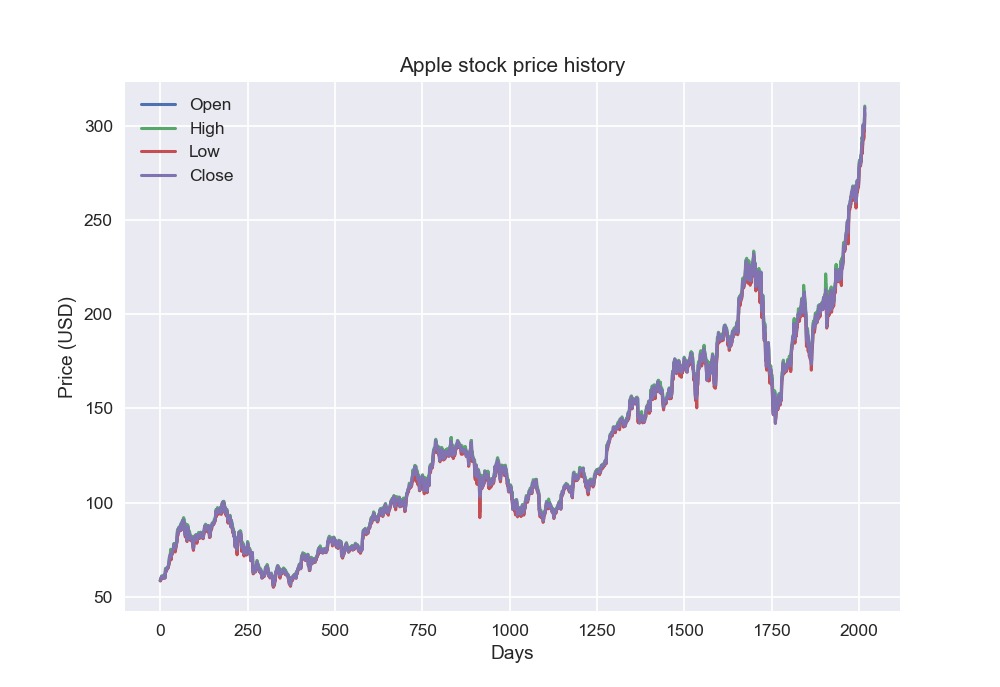

In [96]:
%matplotlib notebook
plt.style.use('seaborn')
plt.figure()
plt.plot(data["Open"])
plt.plot(data["High"])
plt.plot(data["Low"])
plt.plot(data["Close"])
plt.title('Apple stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


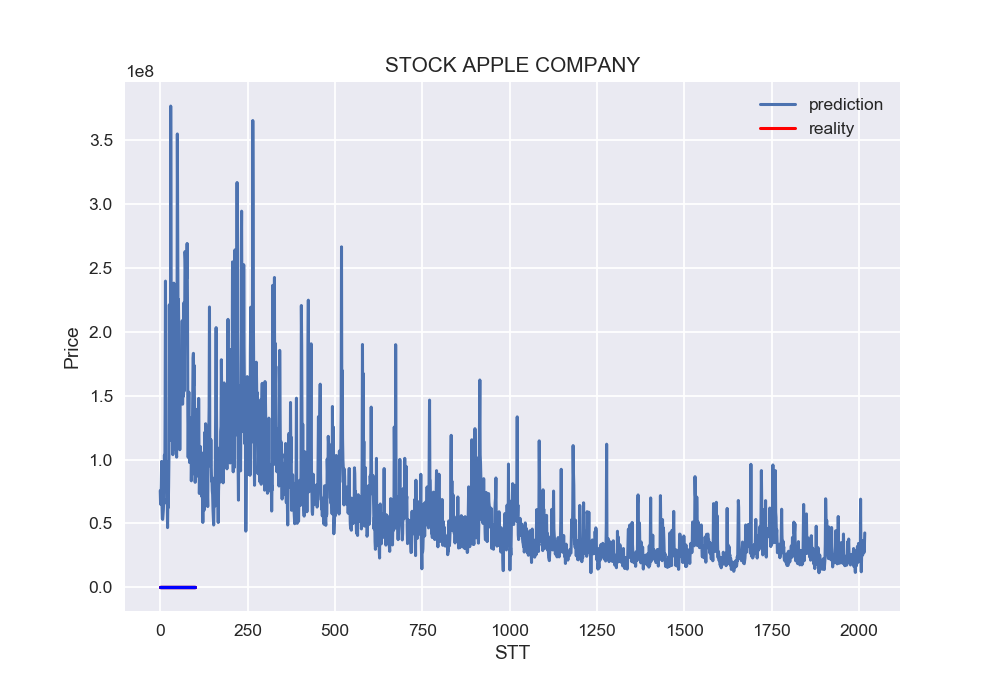

In [99]:
plt.figure()
plt.plot(data["Volume"])
plt.title('Apple stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [101]:
print("checking if any null values are present\n", data.isna().sum())

checking if any null values are present
 Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


In [82]:
data_end = int(np.floor(0.8*(data.shape[0])))

train = data[0:data_end]['Open']
train = train.values.reshape(-1)

test = data[data_end:]['Open'].values.reshape(-1)

date_test = data[data_end:]['Date'].values.reshape(-1)

In [84]:
def get_data(train,test,time_step,num_predict,date):
    x_train= list()
    y_train = list()
    x_test = list()
    y_test = list()
    date_test= list()

    for i in range(0,len(train) - time_step - num_predict):
        x_train.append(train[i:i+time_step])
        y_train.append(train[i+time_step:i+time_step+num_predict])

    for i in range(0, len(test) - time_step - num_predict):
        x_test.append(test[i:i+time_step])
        y_test.append(test[i+time_step:i+time_step+num_predict])
        date_test.append(date[i+time_step:i+time_step+num_predict])
  
    return np.asarray(x_train), np.asarray(y_train), np.asarray(x_test), \
                                                    np.asarray(y_test), np.asarray(date_test)

In [88]:
x_train, y_train, x_test, y_test, date_test = get_data(train,test,30,1, date_test)

# Đưa giá trị về khoảng 0 -> 1 cho tập train
scaler = MinMaxScaler()
x_train = x_train.reshape(-1,30)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

# Đưa giá trị về khoảng 0 -> 1 cho tập test
x_test = x_test.reshape(-1,30)

x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test)

In [89]:
# Reshape lại cho phù hợp với model
x_train = x_train.reshape(-1,30,1)
y_train = y_train.reshape(-1,1)

# Reshape x_test, y_test
x_test = x_test.reshape(-1,30,1)
y_test = y_test.reshape(-1,1)
date_test = date_test.reshape(-1,1)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1583, 30, 1)
y_train shape: (1583, 1)
x_test shape: (373, 30, 1)
y_test shape: (373, 1)


In [119]:
# Build model
n_input = 30
n_features = 1

model = Sequential()
model.add(LSTM(units=50,activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=50))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [162]:
model.compile(optimizer='adam', loss='mse')

In [163]:
# Training model
history = model.fit(x_train, y_train, epochs=500, validation_split=0.2, verbose=1, batch_size=30)
model.save('lstm_model.h5')

Epoch 1/500
43/43 [==============================] - 3s 62ms/step - loss: 4.6040e-04 - val_loss: 0.0266
Epoch 2/500
43/43 [==============================] - 2s 43ms/step - loss: 4.7566e-04 - val_loss: 0.0185
Epoch 3/500
43/43 [==============================] - 2s 42ms/step - loss: 5.0629e-04 - val_loss: 0.0253
Epoch 4/500
43/43 [==============================] - 2s 45ms/step - loss: 4.6344e-04 - val_loss: 0.0201
Epoch 5/500
43/43 [==============================] - 2s 40ms/step - loss: 4.8353e-04 - val_loss: 0.0173
Epoch 6/500
43/43 [==============================] - 2s 40ms/step - loss: 4.3606e-04 - val_loss: 0.0102
Epoch 7/500
43/43 [==============================] - 2s 40ms/step - loss: 4.8337e-04 - val_loss: 0.0105
Epoch 8/500
43/43 [==============================] - 2s 45ms/step - loss: 5.1340e-04 - val_loss: 0.0110
Epoch 9/500
43/43 [==============================] - 2s 45ms/step - loss: 4.4425e-04 - val_loss: 0.0170
Epoch 10/500
43/43 [==============================] - 2s 41ms/st

43/43 [==============================] - 2s 50ms/step - loss: 4.5409e-04 - val_loss: 0.0167
Epoch 80/500
43/43 [==============================] - 2s 41ms/step - loss: 4.5085e-04 - val_loss: 0.0211
Epoch 81/500
43/43 [==============================] - 2s 52ms/step - loss: 4.5253e-04 - val_loss: 0.0223
Epoch 82/500
43/43 [==============================] - 3s 63ms/step - loss: 4.6789e-04 - val_loss: 0.0259
Epoch 83/500
43/43 [==============================] - 3s 59ms/step - loss: 4.5437e-04 - val_loss: 0.0220
Epoch 84/500
43/43 [==============================] - 2s 51ms/step - loss: 4.5637e-04 - val_loss: 0.0185
Epoch 85/500
43/43 [==============================] - 3s 62ms/step - loss: 4.6368e-04 - val_loss: 0.0277
Epoch 86/500
43/43 [==============================] - 3s 63ms/step - loss: 4.3288e-04 - val_loss: 0.0302
Epoch 87/500
43/43 [==============================] - 2s 54ms/step - loss: 4.3432e-04 - val_loss: 0.0198
Epoch 88/500
43/43 [==============================] - 2s 47ms/step -

43/43 [==============================] - 2s 54ms/step - loss: 4.8502e-04 - val_loss: 0.0211
Epoch 157/500
43/43 [==============================] - 3s 61ms/step - loss: 4.4295e-04 - val_loss: 0.0261
Epoch 158/500
43/43 [==============================] - 3s 62ms/step - loss: 4.4555e-04 - val_loss: 0.0306
Epoch 159/500
43/43 [==============================] - 3s 62ms/step - loss: 4.4041e-04 - val_loss: 0.0229
Epoch 160/500
43/43 [==============================] - 2s 53ms/step - loss: 4.2019e-04 - val_loss: 0.0222
Epoch 161/500
43/43 [==============================] - 3s 61ms/step - loss: 4.9191e-04 - val_loss: 0.0243
Epoch 162/500
43/43 [==============================] - 2s 49ms/step - loss: 4.2595e-04 - val_loss: 0.0289
Epoch 163/500
43/43 [==============================] - 2s 46ms/step - loss: 5.0154e-04 - val_loss: 0.0288
Epoch 164/500
43/43 [==============================] - 2s 46ms/step - loss: 4.5888e-04 - val_loss: 0.0195
Epoch 165/500
43/43 [==============================] - 2s 51

43/43 [==============================] - 2s 43ms/step - loss: 4.3313e-04 - val_loss: 0.0224
Epoch 234/500
43/43 [==============================] - 2s 42ms/step - loss: 4.4179e-04 - val_loss: 0.0226
Epoch 235/500
43/43 [==============================] - 2s 46ms/step - loss: 4.6846e-04 - val_loss: 0.0188
Epoch 236/500
43/43 [==============================] - 2s 45ms/step - loss: 4.9168e-04 - val_loss: 0.0220
Epoch 237/500
43/43 [==============================] - 2s 44ms/step - loss: 4.3969e-04 - val_loss: 0.0236
Epoch 238/500
43/43 [==============================] - 2s 43ms/step - loss: 4.6264e-04 - val_loss: 0.0296e
Epoch 239/500
43/43 [==============================] - 2s 42ms/step - loss: 4.5052e-04 - val_loss: 0.0255
Epoch 240/500
43/43 [==============================] - 2s 45ms/step - loss: 4.2660e-04 - val_loss: 0.0221
Epoch 241/500
43/43 [==============================] - 2s 43ms/step - loss: 4.4265e-04 - val_loss: 0.0272
Epoch 242/500
43/43 [==============================] - 2s 4

43/43 [==============================] - 2s 40ms/step - loss: 4.1144e-04 - val_loss: 0.0131
Epoch 311/500
43/43 [==============================] - 2s 39ms/step - loss: 4.5615e-04 - val_loss: 0.0119
Epoch 312/500
43/43 [==============================] - 2s 39ms/step - loss: 4.0711e-04 - val_loss: 0.0221
Epoch 313/500
43/43 [==============================] - 2s 40ms/step - loss: 4.1236e-04 - val_loss: 0.0353
Epoch 314/500
43/43 [==============================] - 2s 40ms/step - loss: 4.6164e-04 - val_loss: 0.0147
Epoch 315/500
43/43 [==============================] - 2s 40ms/step - loss: 4.5409e-04 - val_loss: 0.0239
Epoch 316/500
43/43 [==============================] - 2s 40ms/step - loss: 4.1587e-04 - val_loss: 0.0208
Epoch 317/500
43/43 [==============================] - 2s 40ms/step - loss: 4.2992e-04 - val_loss: 0.0304
Epoch 318/500
43/43 [==============================] - 2s 40ms/step - loss: 4.4265e-04 - val_loss: 0.0272
Epoch 319/500
43/43 [==============================] - 2s 45

43/43 [==============================] - 2s 40ms/step - loss: 4.4753e-04 - val_loss: 0.0437
Epoch 388/500
43/43 [==============================] - 2s 39ms/step - loss: 4.3004e-04 - val_loss: 0.0389
Epoch 389/500
43/43 [==============================] - 2s 40ms/step - loss: 3.9910e-04 - val_loss: 0.0365
Epoch 390/500
43/43 [==============================] - 2s 40ms/step - loss: 4.2179e-04 - val_loss: 0.0324
Epoch 391/500
43/43 [==============================] - 2s 39ms/step - loss: 4.0768e-04 - val_loss: 0.0338
Epoch 392/500
43/43 [==============================] - 2s 40ms/step - loss: 4.6352e-04 - val_loss: 0.0256
Epoch 393/500
43/43 [==============================] - 2s 40ms/step - loss: 4.3176e-04 - val_loss: 0.0248
Epoch 394/500
43/43 [==============================] - 2s 40ms/step - loss: 4.1524e-04 - val_loss: 0.0253
Epoch 395/500
43/43 [==============================] - 2s 41ms/step - loss: 5.0400e-04 - val_loss: 0.0308
Epoch 396/500
43/43 [==============================] - 2s 40

43/43 [==============================] - 2s 40ms/step - loss: 3.9142e-04 - val_loss: 0.0336
Epoch 465/500
43/43 [==============================] - 2s 40ms/step - loss: 4.7365e-04 - val_loss: 0.0322
Epoch 466/500
43/43 [==============================] - 2s 40ms/step - loss: 4.2107e-04 - val_loss: 0.0330
Epoch 467/500
43/43 [==============================] - 2s 41ms/step - loss: 4.1715e-04 - val_loss: 0.0398
Epoch 468/500
43/43 [==============================] - 2s 40ms/step - loss: 4.5047e-04 - val_loss: 0.0371
Epoch 469/500
43/43 [==============================] - 2s 41ms/step - loss: 4.0321e-04 - val_loss: 0.0298
Epoch 470/500
43/43 [==============================] - 2s 40ms/step - loss: 4.0127e-04 - val_loss: 0.0204
Epoch 471/500
43/43 [==============================] - 2s 41ms/step - loss: 4.3090e-04 - val_loss: 0.0258
Epoch 472/500
43/43 [==============================] - 2s 41ms/step - loss: 4.1837e-04 - val_loss: 0.0258
Epoch 473/500
43/43 [==============================] - 2s 40

<IPython.core.display.Javascript object>


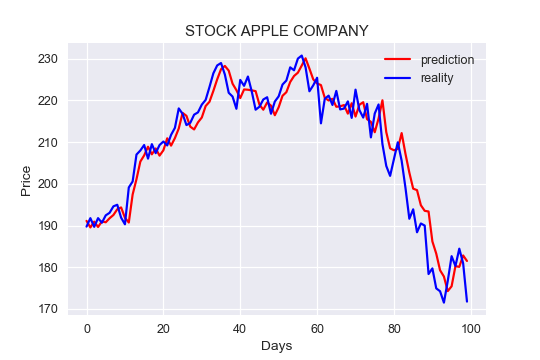

In [174]:
%matplotlib notebook

model = keras.models.load_model('lstm_model.h5')

test_output = model.predict(x_test)

# print(test_output)
test_predict = scaler.inverse_transform(test_output)
test_actual = scaler.inverse_transform(y_test)

plt.plot(test_predict[:100], color='r')
plt.plot(test_actual[:100] ,color='b')
plt.title("STOCK APPLE COMPANY")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(('prediction', 'reality'),loc='upper right')
plt.show()

In [175]:
test_predict = scaler.inverse_transform(test_output)
test_actual = scaler.inverse_transform(y_test)

In [177]:
# Model evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(test_actual, test_predict)
rmse = sqrt(mse)
print("Test set:")
print('Mean square error = ', mse)
print('Root mean square error = ', rmse)

Test set:
Mean square error =  79.15203107792718
Root mean square error =  8.896742722925463
